![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

## Colab Setup

In [ ]:
import json, os
import sys

if 'google.colab' in sys.modules:
    from google.colab import files

    if 'spark_ocr.json' not in os.listdir():
      license_keys = files.upload()
      os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

Saving spark-license-v510.json to spark-license-v510.json


In [ ]:
!pip install transformers
!pip install ipython-autotime

# Installing pyspark and spark-nlp
%pip install --upgrade -q pyspark==3.2.1 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
#! pip uninstall spark-ocr -Y
%pip install spark-ocr==$OCR_VERSION --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.2/531.2 kB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 kB 23.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://pypi.johnsnowlabs.com/5.1.0-9ae60c0a29d554be1e82cff63685565717c509ae
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.3/536.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

## Initialize Spark Session

In [ ]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [ ]:
import pkg_resources

from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *
from sparkocr.metrics import score

In [ ]:
# Start spark
spark = start(secret=SPARK_OCR_SECRET, nlp_version=PUBLIC_VERSION)

Spark version: 3.2.1
Spark NLP version: 5.1.2
Spark OCR version: 5.1.0



## Read images and display it


    Image #0:
    Origin: file:/content/images/descarga.jfif
    Resolution: 0 dpi
    Width: 601 px
    Height: 792 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


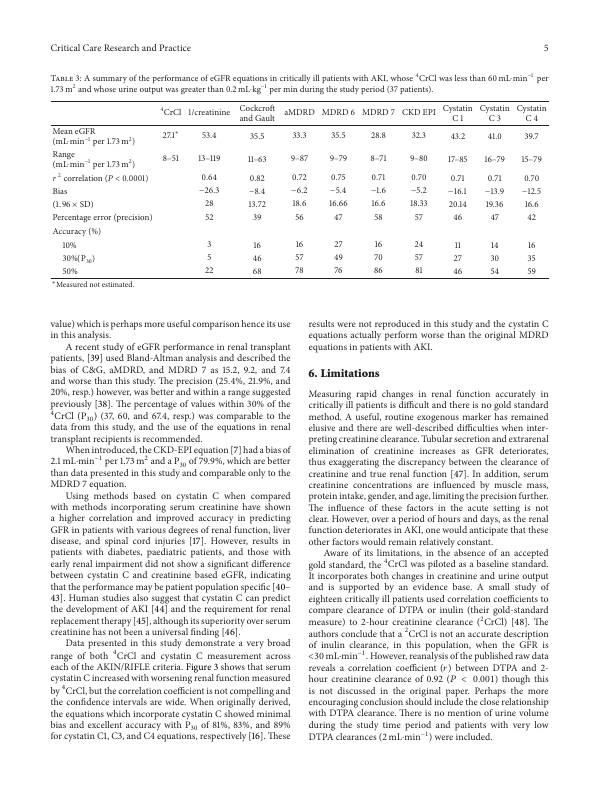


    Image #1:
    Origin: file:/content/images/printed_4.png
    Resolution: 105 dpi
    Width: 959 px
    Height: 761 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


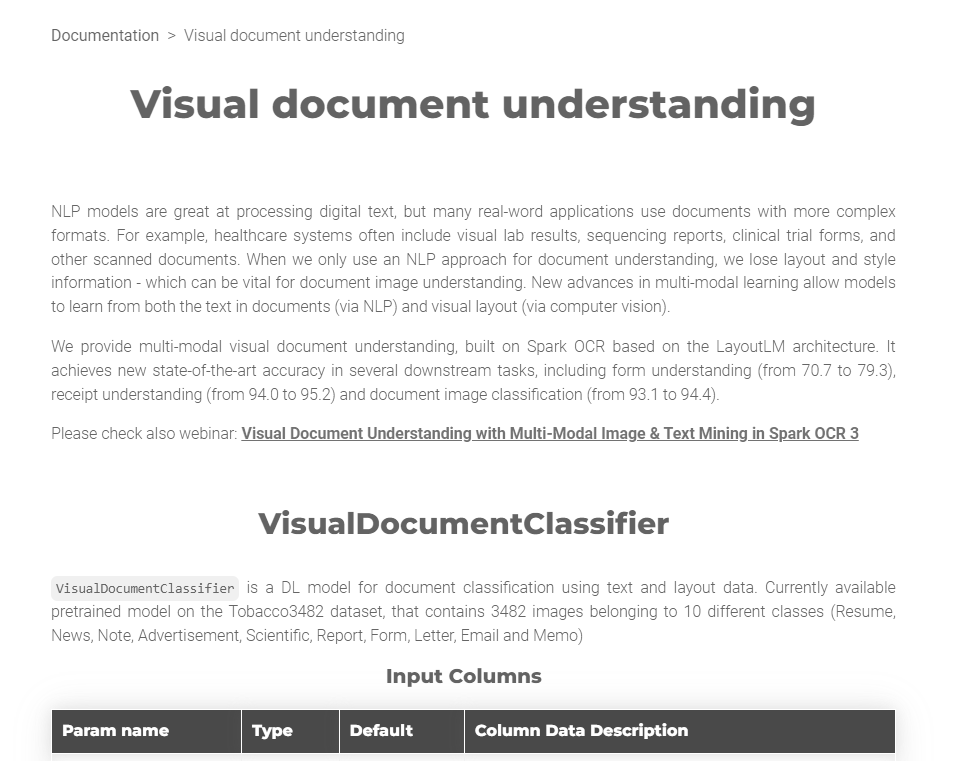


    Image #2:
    Origin: file:/content/images/printed_3.png
    Resolution: 105 dpi
    Width: 696 px
    Height: 857 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


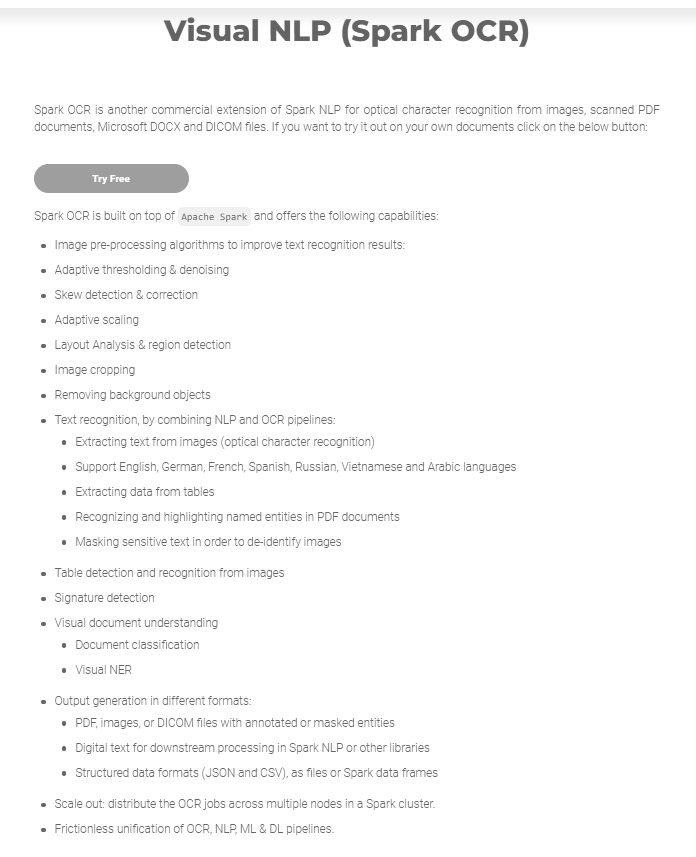

In [ ]:
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images

imagePath = "/content/images"
image_df = spark.read.format("binaryFile").load(imagePath)
display_images(BinaryToImage().transform(image_df), "image")

## Load Pipeline


In [ ]:
binary_to_image = BinaryToImage()
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

dit_layout = ImageLayoutAnalyzerDit \
    .pretrained("publaynet_dit_base_mrcnn", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("regions") \
    .setScoreThreshold(0.5)

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green)
    # .setRotated(True)

pipeline = PipelineModel(stages=[
    binary_to_image,
    dit_layout,
    draw_regions
])

publaynet_dit_base_mrcnn download started this may take some time.
Approximate size to download 401.1 MB


## Call the pipeline


    Image #0:
    Origin: file:/content/images/descarga.jfif
    Resolution: 0 dpi
    Width: 601 px
    Height: 792 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


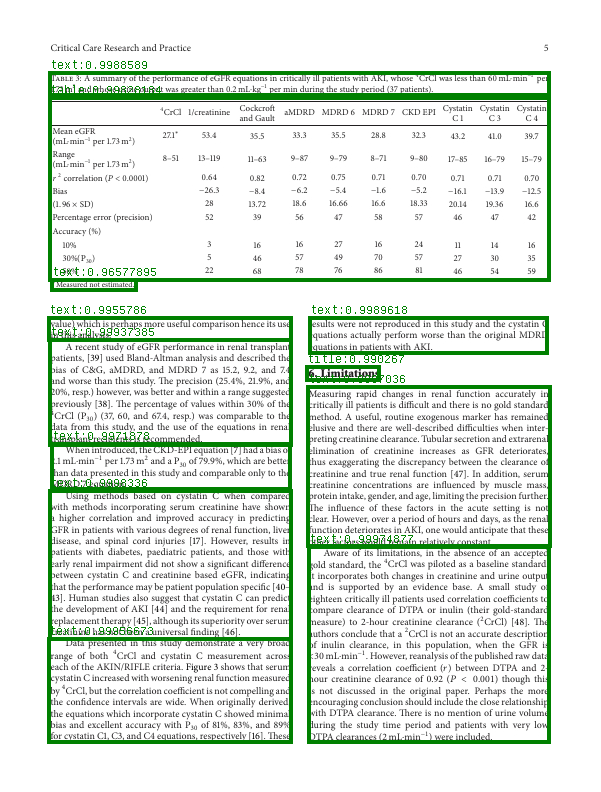


    Image #1:
    Origin: file:/content/images/printed_4.png
    Resolution: 0 dpi
    Width: 959 px
    Height: 761 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


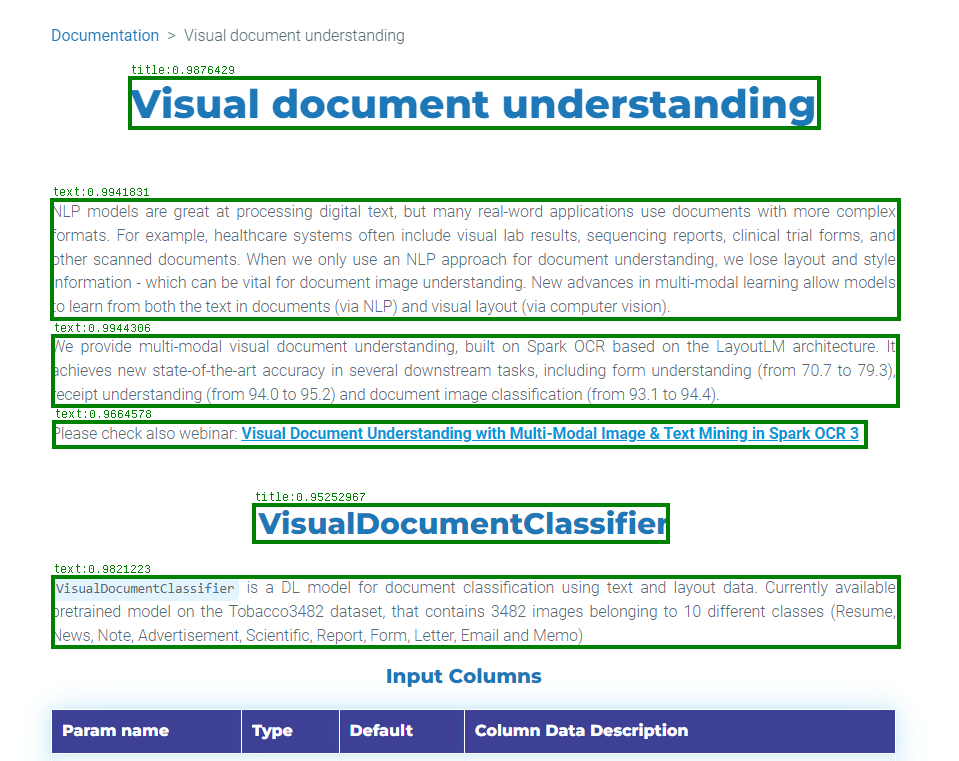


    Image #2:
    Origin: file:/content/images/printed_3.png
    Resolution: 0 dpi
    Width: 696 px
    Height: 857 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


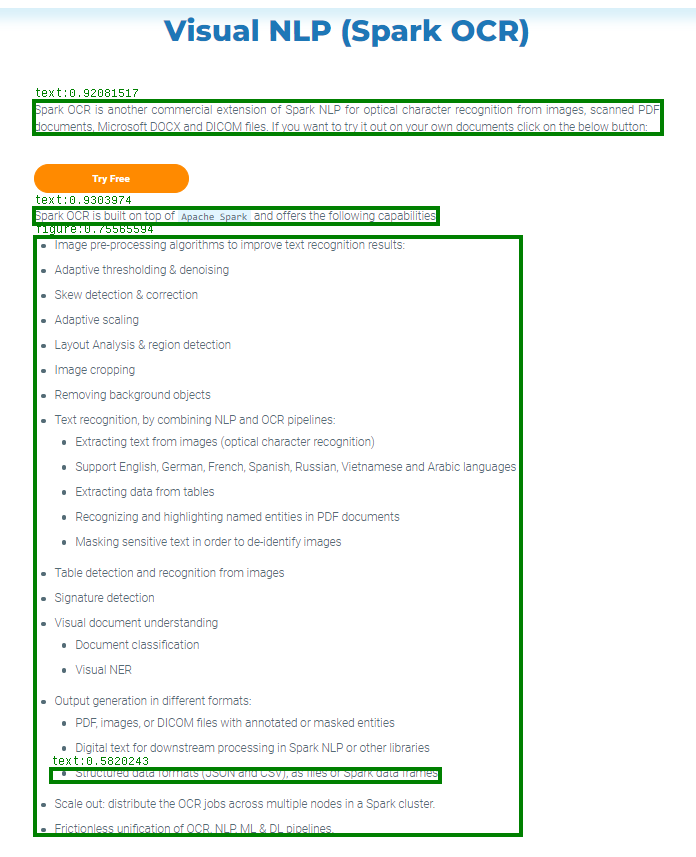

In [ ]:
result = pipeline.transform(image_df).cache()
display_images(result, "image_with_regions")